In [101]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [102]:
folder = "./data"
training_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(os.path.join(folder, training_path))
#test_df = pd.read_csv(os.path.join(folder, test_path))

In [164]:
train_df.drop(labels="id", inplace=True, axis=1)

In [105]:
train_df.isna().sum().sum() # No missing values

0

In [165]:
#train_df.describe()

## Testing normality of attributes, and if they're not trying to transform them
An important decision point when working with a sample of data is whether to use parametric or nonparametric statistical methods.

Parametric statistical methods assume that the data has a known and specific distribution, often a Gaussian distribution. If a data sample is not Gaussian, then the assumptions of parametric statistical tests are violated and nonparametric statistical methods must be used.

## 1 Using histograms
Easy to do, quite fast and I think the easiest to interpret as histogram is just very crude estimation of the distribution.

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'f3'}>]], dtype=object)

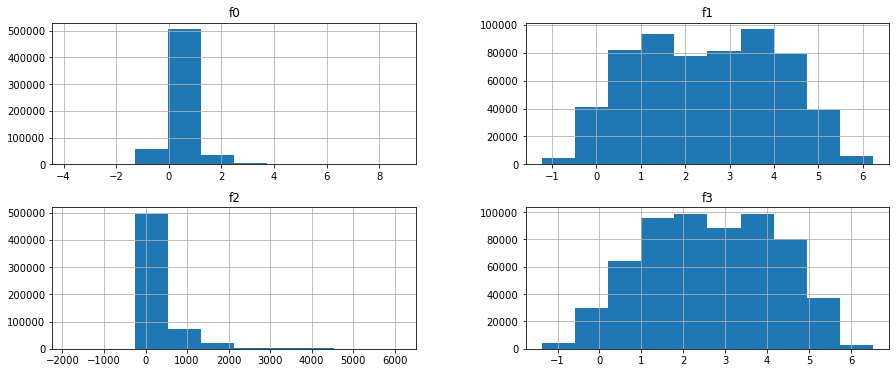

In [107]:
train_df.hist(column=["f0", "f1", "f2", "f3"],figsize=(15,6))
# f0 looks like may be normal with extremally low std.dev. f1 looks like it is sum of to normal distributions. f2 like exponential one
# So we may perform some transformation to make it more normal, and f3 looks like a normal one. But you see that this is doable for a few variables
# But here we have 103, so it's not convenient to analyze 103 histograms

## 2 Using QQ plots
These are just plot of respective quantiles of the distribution. Normal distribution has some specific quantiles and we check if our distribution has similar.<br>
So if our data is distributed normally we would love to see a diagonal line. <br>
But we can make this test for any possible distribution, if line is at 45&deg; angle then our distributions are very similar

In [7]:
from statsmodels.graphics.gofplots import qqplot

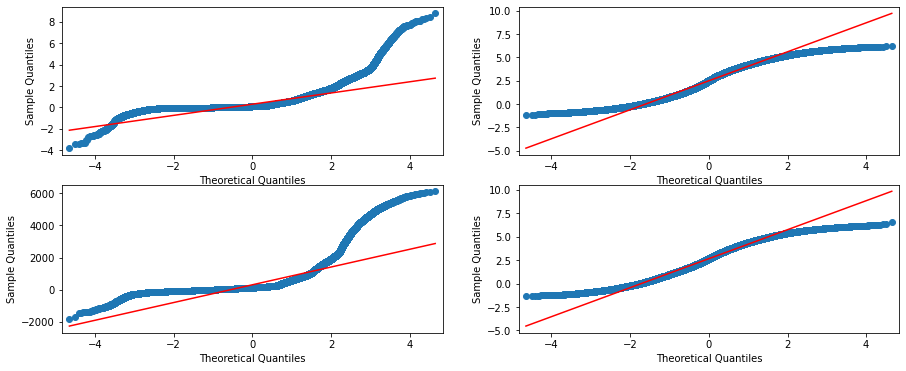

In [108]:
#From here we see that, probably our distributions are not so normal off the shelf.
fig,ax= plt.subplots(2,2,figsize=(15,6))
row = 0
columns = 0
for column in train_df.columns[:4]:
    qqplot(train_df[column].values, line="s", ax=ax[row][columns])
    columns+=1
    if columns == 2:
        columns=0
        row+=1

### Statistical tests
There are tests in which null hypothesis: Data is normally distributed. We calculate statistic for it and then it's p-value. If p-value is less than 0.05 we can reject the hypothesis otherwise we can't and we may assume that data is normally distributed. So we seek for high p-values and we are happy to see them.<br>
Possible tests:
* Shapiro-Wilk (there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.) So it's not our case
* D’Agostino’s K^2 Test - Calculates kurtosis (weight of the tails of distribution) and skewness and based on that. Normal distribution has Kurtosis equal to 3.
* Anderson-Darling Test This is a modification goodness-of-fit statistical test. But this return only critical values not the p ones. But we can also use critical values to reject hypothesis

Now there are 2 approaches
* Consider data as normally distributed if and only if all tests sucedeed
* Consider data as normally distributed if any of them sucedeed

In [9]:
#! Here we obtain the warning that this method is not suited for big N 
from scipy.stats import shapiro
stat, p = shapiro(train_df["f0"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.661, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\sebas\Miniconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [10]:
from scipy.stats import normaltest #D'Agostino one
stat, p = normaltest(train_df["f0"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=429472.676, p=0.000
Sample does not look Gaussian (reject H0)


In [11]:
from scipy.stats import anderson

result = anderson(train_df["f0"])
print('Statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 63884.460
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


### So all methods are sure that f0 is not normally distributed. Lets check it for all atributes using K^2 test

In [109]:
normal = []
not_normal = []
alpha = 0.05
for column in train_df.columns:
    stat, p = normaltest(train_df[column])
    if p > alpha: # can't reject hypothesis that distribution is normal
        normal.append(column)
    else:
        not_normal.append(column)

In [110]:
# So all of the attributes seems not to be normal!
len(normal)
len(not_normal)


101

# Make attributes normal again!
Some of the attributes looks really gaussian like but they didn't passs the tests for normality. Tests have more statistical power so it is better to believe them that eyes but we may try to transform attributes to be more Gaussian. <br><br>
Our sample size is 600k so Law of large numbers should provide that that these sample describe underlying distribution well.

We can try two things:
* remove outliers or long tails that may in fact distort the distribution
* Use some kind of power Transforms (logarithm or square root). BoxCox function may be used (assumes all data values are positive) or yeo-johnson (data can be negative and positive)


### Trying power transforms

In [111]:
from scipy.stats import yeojohnson
def transform_and_check_normality(df, lmbda = None, alpha = 0.05, plot=False, ax = None):
    normal = []
    if ax is not None:
        plot_column = 0
    for column in df.columns:
        if lmbda:
            transformed = yeojohnson(df[column], lmbda=lmbda)
        else:
            transformed, lmbda = yeojohnson(df[column]) # If we do not provide lambda it select the best one 
        stat, p = normaltest(transformed)
        if p > alpha:
            normal.append(column)
            
        if plot:
            if ax is not None:
                #print(lmbda)
                ax[0][plot_column].hist(df[column])
                ax[1][plot_column].hist(transformed)
                ax[0][plot_column].set_title("Before")
                ax[1][plot_column].set_title("After")
                plot_column+=1
            else:
                plt.hist(transformed)
                plt.title(column)
    
    return normal
    

In [112]:
print(np.sum(np.sum(train_df[train_df < 0]))) # A lot of values are negative so we should use the yeo-johnson
lambdas = [-1, -0.5, 0, 0.5 ,2] # values to try. But actually this functions can try to choose best lambda based on log-likelihood function
# !Unfortunatelly even after transformation data is not normally distributed.
# for lmbda in lambdas:
#     print(transform_and_check_normality(train_df, lmbda)) 

print(transform_and_check_normality(train_df)) # Still bad  results 

-6401527.665725382
[]


[]

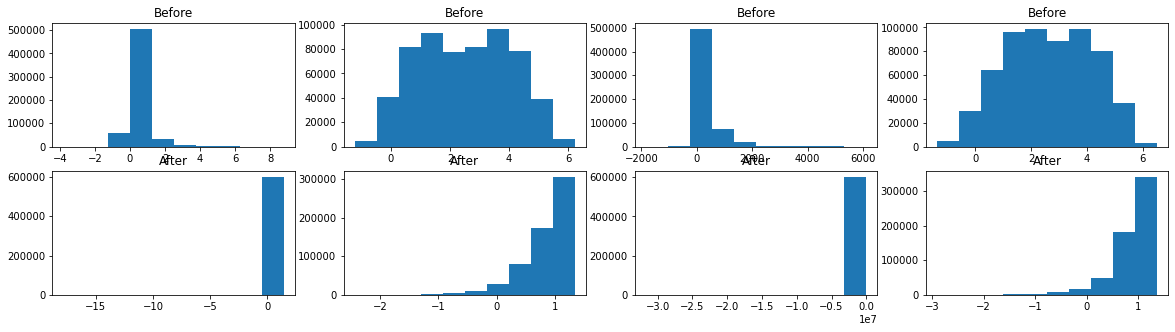

In [113]:
# But try to visualize first 4 after transformation
fig, ax = plt.subplots(2,4, figsize =(20,5))
#Actually this transformation makes situation even worse
transform_and_check_normality(train_df.iloc[:, :4], plot=True,ax=ax) #loc is label based (possible to use boolean arrays), iloc is integer based

### Trying to remove outliers which may distorted distribution and we fail to see that it is normal

In [114]:
# Since it is hard to predict what is a good value of being the outlier I considered to use some defined quantiles for it
# We can use some more sophisticated not parametric methods for detecting outliers I'll do it later
def remove_outsiders_quantile_and_test_normality(df, how_many = 0.05, alpha = 0.05): # By default we want to remove 5% of the most outlied values.
    normal = []
    how_many = how_many/2 #we will take the same amount from the left and right.
    for column in df.columns:
        data = df[column]
        lower_quantile = data.quantile(q=how_many)
        higher_quantile = data.quantile(q=1-how_many)
        transformed = data.drop(data[data < lower_quantile].index)
        transformed.drop(transformed[transformed > higher_quantile].index, inplace=True)
        
        stat, p = normaltest(transformed)
        if p > alpha:
           normal.append(column)
           
    return normal
    

In [115]:
remove_outsiders_quantile_and_test_normality(train_df, how_many=0.02) # still not normal, maybe better way of detecting outliers would help 

[]

### After this analysis we conclude that data is rather not normal. So for sure we shouldn't use parametric methods that assume the attributes are normally distributed, non parametric method is preferred. Morover we should not use the zscore to eliminate outliers as it also assumes that data is distributed normally.

### Removing outliers:
Possibilities:
* based on how many deviations they are from the mean using z-score. But this may be dangerous as we at the beginning assume normal distribution of the variables (parametric approach). So to use it we need to preserve that variables are distributed normally. We can perform some transformation of it.
* Removing values that are away from interquartile range. Usually we remove numbers that are below 1.5Q1 and above 1.5Q3
* Non parametric method Dbscan -> complexity O(nlogn) cons of it is that we need to set some parameters and method is sensitive to them or 
* Non parametric method Isolation Forest that is quite new method 


### Using IQR range
Quite important fact about BoxPlot is that the whiskers do not extend to the minimum and maximum of the sample, but to the smallest and largest values inside a "reasonable" distance from the end of the box. The reasonable distance is defined as 1.5*IQR and the IQR range is just Q3-Q1.
So the "reasonable" range is as follow: [Q1 - 1.5*IQR, Q3 + 1.5*IQR] so minimum and maximum values within this subsets constitute the end of the whiskers. all values that are not in the range are denoted as circles on the boxplot and these may be outliers. Sometimes we can distinguish betwen empty circle and filled one, The filled one is even bigger outlier as it it more than 3IQR from the first of third quantile.

So this methods may be quite drastic, and for dataset with a lot of columns may be not recommended. Since it removes records even if only one attribute does not li within 1.5IQR range!

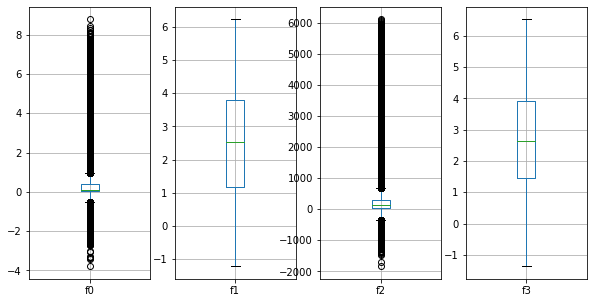

In [117]:
fig, ax = plt.subplots(1,4, figsize=(10,5))
for i, column in enumerate(train_df.columns[:4]):
    train_df.boxplot(column=column, ax=ax[i]) # showfliers=False If there are many outliers this may be useful. whis=3 i the multiplier
    #of the IQR range, we may see that for some attributes we have really a lot of outliers, as the distributions are probably exponential

In [119]:
def remove_outliers_IQR_method(df, multiplier=1.5):
    df_no_outliers = df.copy()
     #I'm rejecting the id column
    for column in df_no_outliers.columns:
        q25 = df_no_outliers[column].quantile(q=0.25)
        q75 = df_no_outliers[column].quantile(q=0.75)
        iqr = q75 - q25
        cutoff = multiplier * iqr
        lower, upper = q25-cutoff, q75+cutoff
        
        df_no_outliers = df_no_outliers[(df_no_outliers[column] > lower) & (df_no_outliers[column] < upper)] #Leaving only things within the interval
        
    return df_no_outliers
        

(59098, 101)


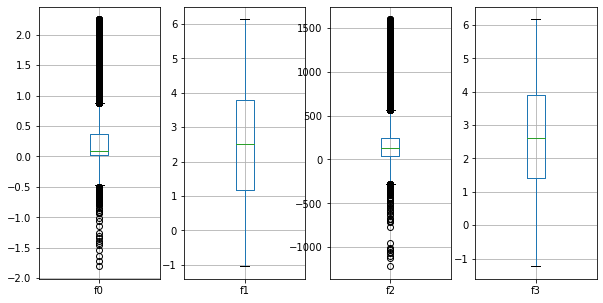

In [125]:
train_df_no_outliers = remove_outliers_IQR_method(train_df, multiplier=5)
print(train_df_no_outliers.shape) # We removed Almost ALL data points using multipler: 1.5, since we have a lot of columns! If only one of the attributes is outlier we drop entire row!
fig, ax = plt.subplots(1,4, figsize=(10,5))
for i, column in enumerate(train_df_no_outliers.columns[:4]):
    train_df_no_outliers.boxplot(column=column, ax=ax[i]) 
#! Interesting fact is that we can still see "outliers". But it is okay as we probably moved the median and other quantiles to the other direction

In [126]:
def remove_outliers_percentile_method(df, percent_to_be_removed = 0.005):
    percent_to_be_removed /= 2
    left = df.quantile(percent_to_be_removed)
    right = df.quantile(1-percent_to_be_removed)
    
    # So I at first have true for any row that contains an outlier, then I negate this array
    return df[~((df < left) | (df > right)).any(axis=1)]

In [127]:
train_df_no_outliers = remove_outliers_percentile_method(train_df)
train_df_no_outliers.shape # This way we removed less rows but still substantial amount

(365469, 101)

## Trying DbScan
Using DbScan we need to set two parameters:
* epsilon: specifies how close points should be to each other to be considered a part of a cluster. A good approach is to try values ranging from 0.25 to 0.75
* minPoints: the minimum number of points to form a dense region. General rule of thumb may be to set this value to be greater than number_of_dimensions +1 and the bigger the dataset the bigger this value should be

To set them correctly it is beneficial to have some prior knowledge about the data. But here we don't know anything so we should be careful.

Before using DbScan it is very important to scale our features as if we have some attribute expressed in very big numbers then epsilon=0.5 may classify everyone as outlier!. Or we can also measure distances to K-Nearest neighbours and set some value using this method and plotting K-distance Graph.

Unfortunatelly as the dimension of data increases, it becomes difficult for DBSCAN to create clusters and it falls prey to the Curse of Dimensionality. But at least we can try.

### DISCLAIMER: DBSCAN is very slow and consumes a lot of memory for large datasets as it also must calculate a lot of pairwise distances. Even though scans through the entire dataset only once.


In [130]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(train_df)
train_df_scaled = transformer.transform(train_df) #The problem with that scaler is that we still have a lot of data with big magnitude
#So we need to set up epsilon carefully and select some value from K-distance graph

In [138]:
# We can create K-distance graph using NearestNeighbors
#! This will take a lot of time as we have 101 attributes and 600k rows So this is not the good way
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train_df_scaled) 
distances, indices = nbrs.kneighbors(train_df_scaled)

In [146]:
from sklearn.preprocessing import MinMaxScaler #After using this scaler I'll be more save to use some default epsilon
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)

In [150]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(train_df)

### Isolation forest
This method tries to isolate samples by splitting them on some random values of some attributes. The longer the path of isolation the less chance of being anomaly. The shorter path the greater this chance is. This algorithm actually is quite efficient and should be okay for our big dataset.

It is written in paper about this method that it has a linear time complexity with a low constant and a low memory requirement.

After training our model we can make predictions and outliers will be labeled with prediction equal to -1

Probably the most important parameter is contamination:
* The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples. If ‘auto’, the threshold is determined as in the original paper. If float, the contamination should be in the range (0, 0.5].

In [152]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(train_df) # it trained very fast as it is  O(n)

In [156]:
predictions = clf.predict(train_df) # This will clasify every of our datapoints

In [159]:
print(np.unique(predictions)) # So -1 is anomaly and 1 is not an outlier
print(np.sum(predictions == -1)) # But using default ratio of outliers there are only 7 of them in this dataset

[-1  1]
7


In [160]:
clf2 = IsolationForest(random_state=0, contamination=0.1).fit(train_df) # Lest try to train it with bigger contamination

In [161]:
predictions2 = clf2.predict(train_df) # This will clasify every of our datapoints

In [163]:
print(np.sum(predictions2 == -1)) # !now as expected 10% of our dataset is considered to be outliers 

60000


## Feature selection

The Shapley value requires a lot of computing time. In 99.9% of real-world problems, only the approximate solution is feasible. An exact computation of the Shapley value is computationally expensive because there are 2k possible coalitions of the feature values

(600000, 101)